## Library imports

In [7]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import lfilter
from scipy.signal import butter
import matplotlib.pyplot as plt
from scipy import signal
import librosa.display
import numpy as np
import os

## Function for Bandpass filter

In [8]:
# Creating Butterworth Bandpass Filter
def butter_bandpass(lowcut : int, highcut : int, fs : int, order=5):
    """ Create a Butterworth Bandpass Filter

        \tlowcut: low cut frequency (in Hz)
        \thighcut: high cut frequency (in Hz)
        \tfs: sampling frequency (in Hz)
        \torder: order of the filter (default = 5)

        return: b, a: numerator (b) and denominator (a) polynomials of the IIR filter   """

    nyq = 0.5 * fs                                      # Nyquist frequency (half of the sampling frequency)
    low = lowcut / nyq                                  # Normalized low cut frequency
    high = highcut / nyq                                # Normalized high cut frequency
    b, a = butter(order, [low, high], btype='band')     # Create Butterworth bandpass filter
    return b, a                                         # Return numerator (b) and denominator (a) polynomials of the IIR filter


def butter_bandpass_filter(data, lowcut : int, highcut : int, fs : int, order=5):
    """     Apply a Butterworth Bandpass Filter   
            
            \tdata: signal to be filtered
            \tlowcut: low cut frequency (in Hz)
            \thighcut: high cut frequency (in Hz)
            \tfs: sampling frequency (in Hz)
            \torder: order of the filter (default = 5)

            return: y: filtered signal   """


    b, a = butter_bandpass(lowcut, highcut, fs, order=order)    # Create Butterworth bandpass filter
    y = lfilter(b, a, data)                                     # Apply filter
    return y                                                    # Return filtered signal

## Function for Finding Peak Landmarks (Start, End, and Peak)

In [9]:
def find_start_peak_end(x_filt,windowsize=100):
    """     Find the start, peak and end of the signal
            \tx_filt: filtered signal
            \twindowsize: size of the window to calculate the standard deviation (default = 100)
            return: start, peak, end: start, peak and end of the signal   """

    peak = np.argmax(np.abs(x_filt))    # Find the peak of the signal
    start=0                             # Initialize start 
    end = len(x_filt)                   # Initialize end

    std_cutoff = np.std(x_filt)/10      # Set the standard deviation cutoff

    # Find the start and end of the signal
    for i in range(peak,0,-windowsize):  

        # Calculate the standard deviation of the signal in the window
        std = np.std(x_filt[i:i+windowsize])

        # If the standard deviation is less than the cutoff, set the start of the signal
        if std <= std_cutoff:
            start = i
            break

    # Find the end of the signal
    for j in range(peak,len(x_filt),windowsize):

        # Calculate the standard deviation of the signal in the window
        std = np.std(x_filt[j:j+windowsize])

        # If the standard deviation is less than the cutoff, set the end of the signal
        if std <= std_cutoff:
            end = j
            break
    
    # Sanity check so that end doesn't go out of bounds
    if end==len(x_filt):
        end = len(x_filt)-3201
    
    # Adding 0.1s of margin to end 
    return start,peak,end+3200

## Function for Envelope Detection

In [10]:
# Creating Envelope of the filtered signal
def create_envelope(x_filt,sr : int,fL_hz=10, ripple_db=10.0):
    """ Create an envelope of the filtered signal

        \tx_filt: filtered signal
        \tsr: sampling rate (in Hz)
        \tfL_hz: low cut frequency (in Hz)
        \tripple_db: ripple in the passband (in dB)

        return: envelope_hat_filt: filtered envelope of the filtered signal   """
    
    nyq_rate = sr * 2       # Nyquist rate is twice the sampling rate.
    width = 1.0/nyq_rate    # filter transition width.     
    
    # Hilbert Transform
    x_filt_hilbert = signal.hilbert(x_filt)
    envelope_hat = np.abs(x_filt_hilbert)
    
    # filter the Hilbert envelope
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)

    return envelope_hat_filt

## Spectrogram Visualization

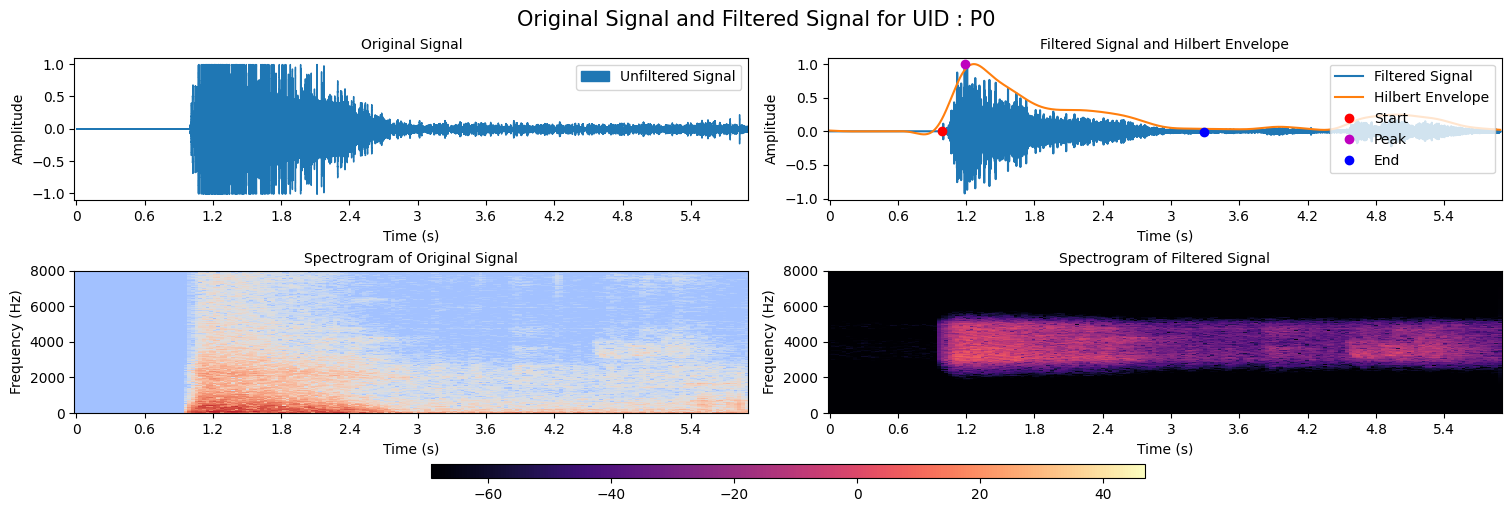

KeyboardInterrupt: 

In [11]:
directory = '../1.Data/SpiroMask_Audio_Samples/'    # Path to the folder containing the audio files

cutoff_low = 3000       # desired cutoff frequency of the filter, Hz
cutoff_high = 5000      # desired cutoff frequency of the filter, Hz
order = 5              # desired order of the filter

ripple_db = 10.0        # stop band attenuation in dB for envelope filter
fL_hz = 10              

pdf_name = "Spectrogram_Band_3000-5000.pdf"   # ----------------> Provide a File Name here <------------------

# IF file already does not exists
if not os.path.exists(pdf_name):
    pdf = PdfPages(pdf_name)

# pdf = PdfPages("Band_1250-2800.pdf")    

# Looping through all the files in the directory
for filename in os.listdir(directory):

    # Path to the file
    f = os.path.join(directory, filename)
    
    # checking if it is a file
    if os.path.isfile(f) :

        # Load Audio File
        x , sr = librosa.load(f,sr=16000)

        # Band pass filtering
        x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,sr,order)

        # Finding the start, peak and end of the signal
        start,peak,end = find_start_peak_end(x_filt)
        
        # Creating the envelope of the filtered signal
        envelope_hat_filt = create_envelope(x_filt,sr,fL_hz,ripple_db)
        t = np.arange(0,len(envelope_hat_filt))/sr

        # Spectrogram of the Original and Filtered Signal
        stft_spectrogram=librosa.amplitude_to_db(np.abs(librosa.stft(x)))
        stft_spectrogram_filt=librosa.amplitude_to_db(np.abs(librosa.stft(x_filt)))

        # Finding the minimum and maximum values of the spectrograms
        minmin = min(stft_spectrogram.min(),stft_spectrogram_filt.min())
        maxmax = max(stft_spectrogram.max(),stft_spectrogram_filt.max())
        
        # Plotting the Original Signal
        fig = plt.figure(figsize=(15, 5),dpi=100,layout='constrained')
        ax1 = plt.subplot(221)
        img1 = librosa.display.waveshow(x, sr=sr,ax=ax1,label='Unfiltered Signal')
        ax1.set_ylabel('Amplitude',fontsize=10)
        ax1.set_title('Original Signal',fontsize=10)
        ax1.set_xlabel('Time (s)',fontsize=10)
        ax1.legend(loc="upper right",fontsize=10,)

        # Plotting the Spectrogram of the Original Signal
        ax2 = plt.subplot(223,sharex=ax1)
        img2 = librosa.display.specshow(stft_spectrogram, sr=sr, x_axis='time',y_axis='hz',ax=ax2, vmin=minmin, vmax=maxmax)
        ax2.set_ylabel('Frequency (Hz)',fontsize=10)
        ax2.set_title('Spectrogram of Original Signal',fontsize=10)
        ax2.set_xlabel('Time (s)',fontsize=10)

        # Plotting the Filtered Signal and Hilbert Envelope
        ax3 = plt.subplot(222)
        ax3.plot(t,x_filt/max(x_filt),label='Filtered Signal')
        ax3.plot(t,envelope_hat_filt/max(envelope_hat_filt),label='Hilbert Envelope')
        ax3.plot(t[start],x_filt[start]/max(x_filt),'ro',label='Start')
        ax3.plot(t[peak],x_filt[peak]/max(x_filt),'mo',label='Peak')
        ax3.plot(t[end],x_filt[end]/max(x_filt),'bo',label='End')
        ax3.set_ylabel('Amplitude',fontsize=10)
        ax3.set_xlabel('Time (s)',fontsize=10)
        ax3.set_title('Filtered Signal and Hilbert Envelope',fontsize=10)
        ax3.legend(loc="upper right",fontsize=10)

        # Plotting the Spectrogram of the Filtered Signal
        ax4 = plt.subplot(224,sharex=ax3)
        img4 = librosa.display.specshow(stft_spectrogram_filt, sr=sr, x_axis='time',y_axis='hz',ax=ax4, vmin=minmin, vmax=maxmax)
        ax4.set_ylabel('Frequency (Hz)',fontsize=10)
        ax4.set_xlabel('Time (s)',fontsize=10)
        ax4.set_title('Spectrogram of Filtered Signal',fontsize=10)

        # Adding colorbar to the spectrograms.
        plt.colorbar(img4,ax=[ax2,ax4],orientation='horizontal',shrink=0.5,aspect=50)

        # Adding Title to the figure
        plt.suptitle("Original Signal and Filtered Signal for UID : {}".format(filename.split('.')[0]),fontsize=15)

        # Saving the figure to the pdf
        pdf.savefig( fig )

        plt.show()

# Closing the pdf
pdf.close()